In [1]:
import fastbook
from fastai.vision.all import *
from fastai.vision.widgets import *
fastbook.setup_book()

# 收集数据集

我们想做一个区分火灾和非火灾的应用
- 利用ddg搜说功能搜素火灾的照片
- 第二个类别使用树林作为无火灾的样本

## 下载数据

以下两行代码可以方便的下载数据
``` python
urls=fastbook.search_images_ddg('fire',max_images=200)
fastbook.download_images(p,urls=urls)
    ...
    ...
faild_files=fastbook.verify_images(fastbook.get_image_files(basepath))
faild.map(Path.unlink)
```

In [2]:
basepath=fastbook.fastai_path('data')/'fire disaster'
catolog=('fire disaster','forest')

In [42]:
if not basepath.exists():
    basepath.mkdir()
for cat in catolog:
    p=basepath/cat
    p.mkdir(exist_ok=True)
    urls=fastbook.search_images_ddg(cat)
    fastbook.download_images(p,urls=urls)
faild=fastbook.verify_images(fastbook.get_image_files(basepath))
faild.map(Path.unlink)

(#0) []

## 查看数据，准备数据集

DataBlock 是我们需要的数据加载对象：
```
blocks=(ImageBlock,CategoryBlock) //确定数据输出的目标
get_items=get_image_files,  //get_image_filess：Path => list[str]
get_y=parent_label,      // parent_label: str => 文件的父级目录
item_tfms=RandomResizedCrop(128,min_scale=0.6), //统一图片大小， 输出的图片占图片内容最小要60%
batch_tfms=aug_transforms()  //数据加强，GPU批量加强，色彩饱和度，反转，旋转，shear,投影变换
```

In [3]:
dataset=DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms=RandomResizedCrop(128,min_scale=0.6),
    batch_tfms=aug_transforms()
)
dataloader=dataset.dataloaders(basepath)

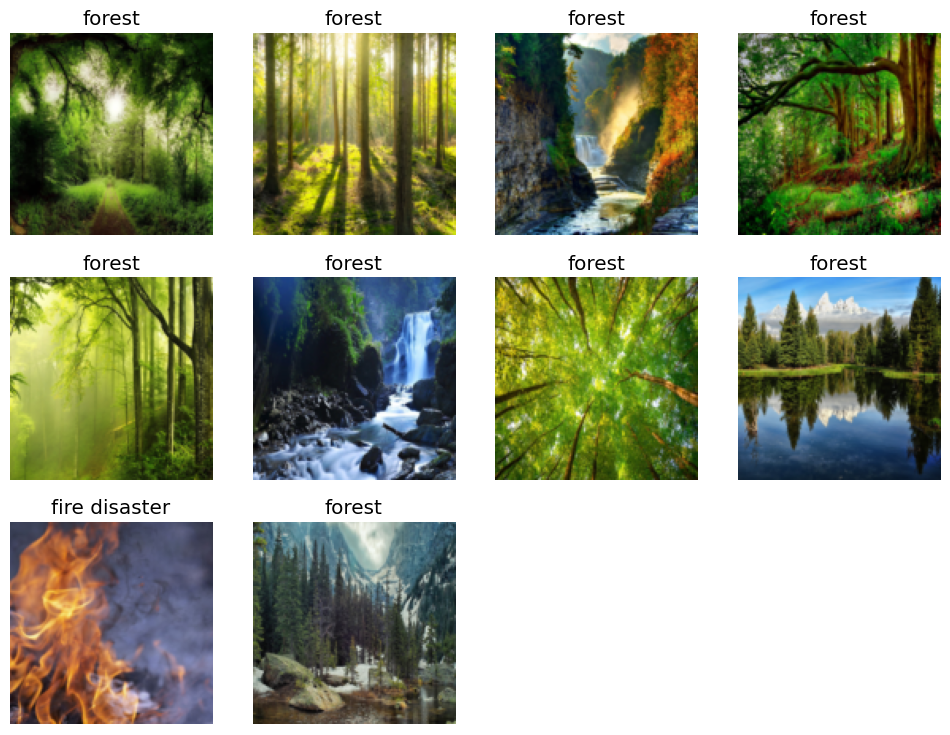

In [4]:
dataloader.valid.show_batch(max_n=10)

# 模型定义 迁移训练

In [5]:
# 创建模型
# learner=vision_learner(dataloader,resnet18,metrics=error_rate)

# 去读模型，重复训练
learner=load_learner('fire_disaster.pkl')
learner.dls=dataloader

SuggestedLRs(valley=7.585775892948732e-05)

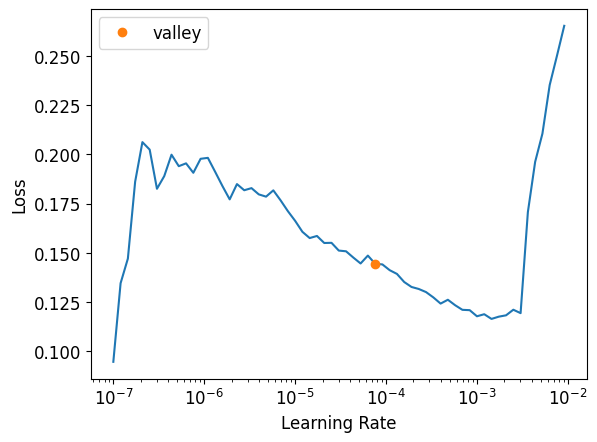

In [7]:
learner.lr_find()

In [7]:
learner.fine_tune(0)

epoch,train_loss,valid_loss,error_rate,time
0,0.098575,0.126150,0.028169,00:43


In [108]:
learner.export('fire_disaster.pkl')

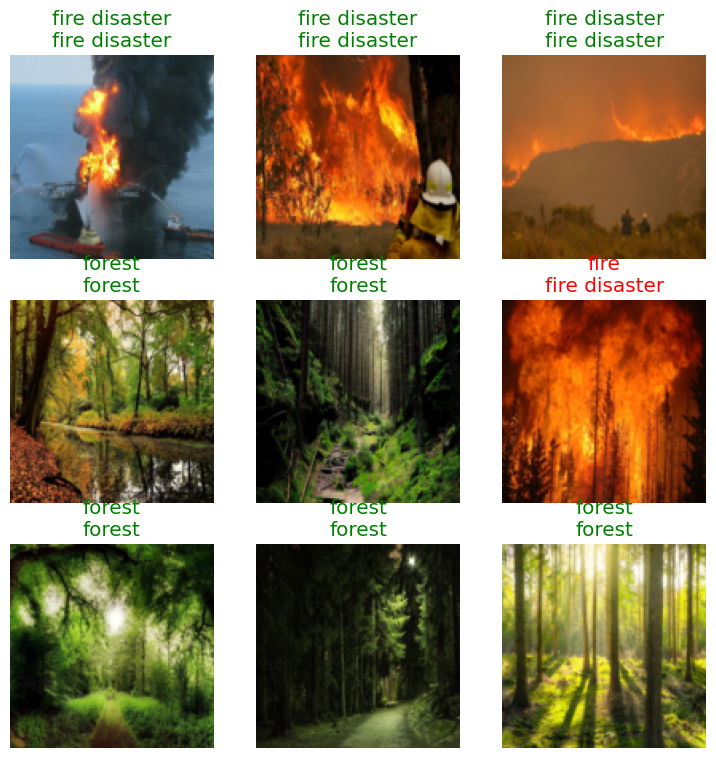

In [6]:
learner.show_results()

## 尝试其他的Arch

In [8]:
import timm

In [15]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [16]:
learner=vision_learner(dataloader,'convnext_tiny_in22k',metrics=error_rate)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\convnext_tiny_22k_224.pth


In [17]:
learner.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.746765,1.939903,0.366197,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.217332,0.762163,0.098592,00:53
1,0.213041,0.551706,0.070423,00:27
2,0.215778,0.504631,0.070423,00:28


In [18]:
learner.export('fire_disaster_convnext.pkl')

# 分析模型，二次清理数据
- ClassificationInterpretation.from_learner 是一个factory方法，直接从learner那获取分析的数据
- ClassificationInterpretation.plot_confusion_matrix(),plot_top_losses(5,ncols=1)
- ImageClassifierCleaner(learner)是一个GUI，用于标记需要删除/更改类别的图片。注意：cleaner不执行真正的清洗工作，在切换下拉框前，需要执行下面代码，让清理生效。
```python
for idx in cleaner.delete():
    Path.unlink(cleaner.fns[idx])
for (idx,cat) in cleaner.change():
    shutil.move(cleaner.fns[idx],basepath/cat)
```

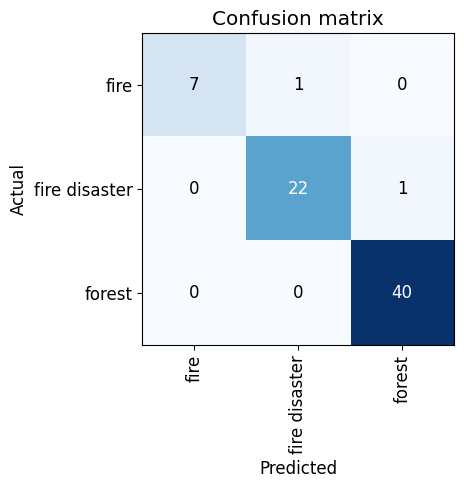

In [9]:
interpretor=ClassificationInterpretation.from_learner(learn=learner)
interpretor.plot_confusion_matrix()

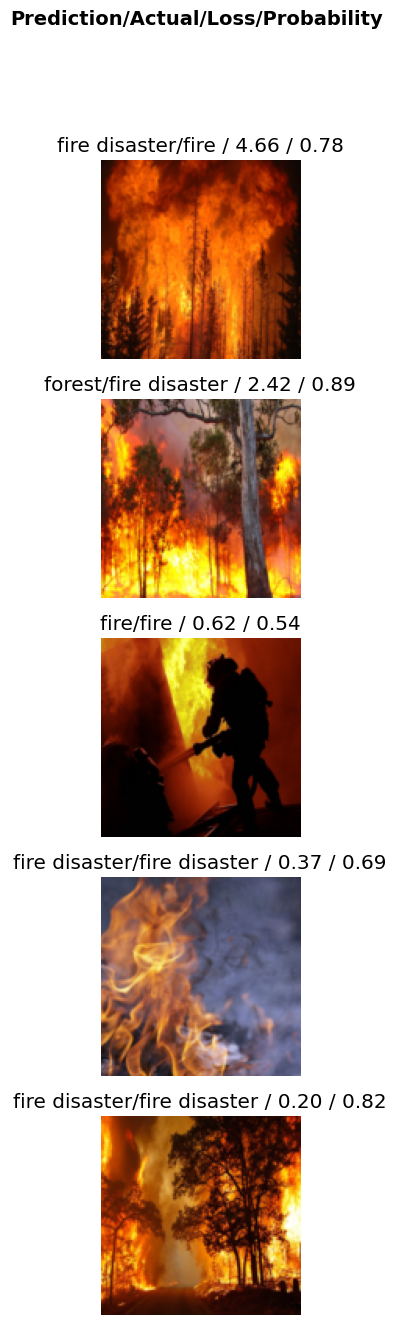

In [10]:
interpretor.plot_top_losses(5,ncols=1,)

In [111]:
cleaner=ImageClassifierCleaner(learner)
cleaner

In [98]:
for idx in cleaner.delete():
    Path.unlink(cleaner.fns[idx])
for (idx,cat) in cleaner.change():
    shutil.move(cleaner.fns[idx],basepath/cat)

## 模型评估
对测试数据进行分析，我们的模型有以下问题：
- 深林里的火灾，模型完全忽略的火灾的属性，而认为这是一张深林图片
- 对城市内火灾（浓烟的特质），不太确定。
- 不能很好区分什么是火焰，什么是火灾

# 上线模型

尽管我们的模型还有种种问题，但是作为第一次迭代，我们可以内部部署一个web版本，供大家平时使用并检验。

[gradio_hf_spaces_tutorial](https://www.tanishq.ai/blog/gradio_hf_spaces_tutorial)

In [2]:
import gradio as gr

In [6]:
learner=load_learner('fire_disaster.pkl')

In [7]:
def predict(img):
    vocab=["火焰","火灾","森林"]
    I=PILImage.create(img)
    _,idx,probs=learner.predict(I)
    return {label:float(probs[idx]) for idx,label in enumerate(vocab)}
# predict(r'C:\Users\Administrator\.fastai\data\fire disaster\fire disaster\93d1c760-f31e-4e5a-96e9-66d41d04a1cc.jpg')

In [22]:
examples=[str(f) for f in get_files(r'data\fire_disaster')]

gui=gr.Interface(fn=predict,inputs=gr.inputs.Image(shape=(512,512)),
                 outputs=gr.outputs.Label(num_top_classes=3),
                examples=examples)
gui.launch()

D:\python\lib\site-packages\gradio\inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
D:\python\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
D:\python\lib\site-packages\gradio\outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
D:\python\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "D:\python\lib\site-packages\PIL\Image.py", line 3096, in open
    fp.seek(0)
AttributeError: 'NoneType' object has no attribute 'seek'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\python\lib\site-packages\gradio\routes.py", line 395, in run_predict
    output = await app.get_blocks().process_api(
  File "D:\python\lib\site-packages\gradio\blocks.py", line 1193, in process_api
    result = await self.call_function(
  File "D:\python\lib\site-packages\gradio\blocks.py", line 916, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "D:\python\lib\site-packages\anyio\to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "D:\python\lib\site-packages\anyio\_backends\_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "D:\python\lib\site-packages\anyio\_backends\_asyncio.py", line 

In [13]:
gui.close()

Closing server running on port: 7861


In [21]:
import nbdev
nbdev.__version__

'2.3.12'

In [14]:
# 下载数据
url=URLs.PETS
# fastai_path('archive') 压缩包下载到此目录中
# fastai_path('data') 数据我呢见 加下到此处
img_path=untar_data(url)/"images"

In [10]:
def is_cat(x):return x[0].isupper()

In [11]:
dls=ImageDataLoaders.from_name_func(".",get_image_files(img_path),is_cat,item_tfms=Resize(192))

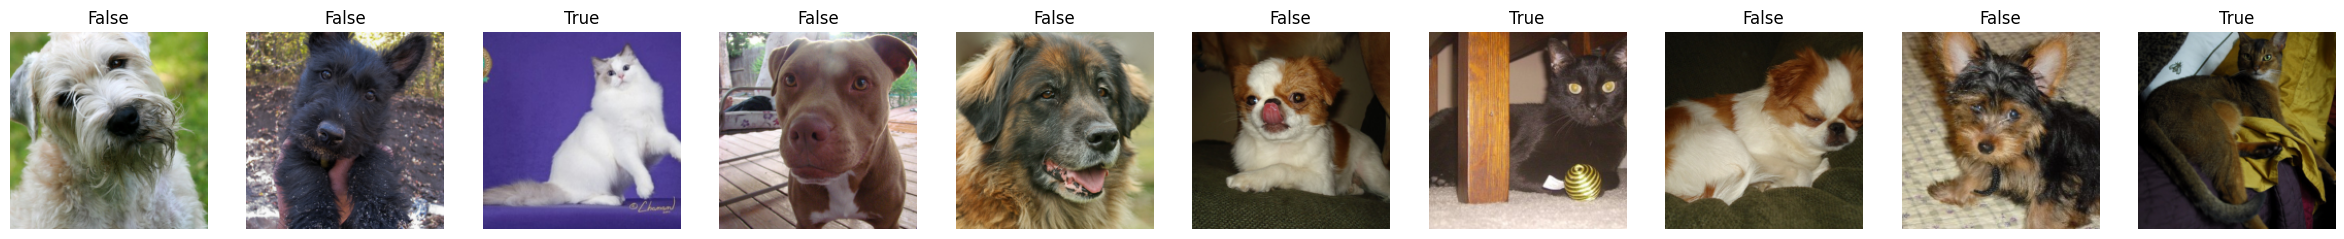

In [12]:
dls.valid.show_batch(max_n=10,nrows=1)

In [14]:
learn=vision_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(3)

D:\python\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\python\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

epoch,train_loss,valid_loss,error_rate,time
0,0.164725,0.069993,0.026387,03:16


epoch,train_loss,valid_loss,error_rate,time
0,0.079910,0.053876,0.016238,01:58
1,0.043277,0.027301,0.007442,02:25
2,0.021815,0.024289,0.008796,02:42


In [15]:
#|export
learn.export('cat_doc_model.pkl')

In [2]:
import nbdev

In [8]:
nbdev.export.nb_export('fastai_deployment.ipynb','fastai_deployment')

d:\python\lib\site-packages\nbdev\export.py:54: UserWarning: Notebook 'fastai_deployment.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [11]:
from nbdev.export import notebook2script
notebook2script()

ImportError: cannot import name 'notebook2script' from 'nbdev.export' (d:\python\lib\site-packages\nbdev\export.py)